In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.tsa.seasonal import seasonal_decompose

from src.plot import plot_single_bath, plot_all_params, save_individual_run, save_bath, plot_conductivity_fft
from src.load_data import load_sheet, clean_sheet_with_label

%load_ext autoreload
%matplotlib
%autoreload 2

ModuleNotFoundError: No module named 'gspread'

In [ ]:
import os

print(os.getcwd())

c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_TSAD-main


In [ ]:
internal_df, sheet1 = load_sheet("Electroplate Experiments Data JUN_JUL", "vary_internal_table")
internal_df = clean_sheet_with_label(internal_df)
# two_side_plate, sheet2 = load_sheet("Electroplate Experiments Data JUN_JUL", "2 side Experimental Result")
# two_side_plate = clean_sheet_with_label(two_side_plate)
august_df, sheet3 = load_sheet("Electroplating Experiments Data August", "Sheet1")
august_df = clean_sheet_with_label(august_df)
september_df, sheet4 = load_sheet("Electroplating Experiments Data September", "Sheet1")
september_df =clean_sheet_with_label(september_df)

internal_df[internal_df['bath_id']=='Bath_3']
combined_df = pd.concat([internal_df, august_df, september_df])

In [ ]:
jul_22_3 = combined_df[combined_df['run_id']=='JUL_22_3'].copy()
print(f'Anomaly C type: {jul_22_3['Anomaly C'].unique()}')
print(f'Anomaly P type: {jul_22_3['Anomaly P'].unique()}')
print(f'Anomaly T type: {jul_22_3['Anomaly T'].unique()}')
print(f'Anomaly V type: {jul_22_3['Anomaly V'].unique()}')

Anomaly C type: ['C3']
Anomaly P type: ['N']
Anomaly T type: ['N']
Anomaly V type: ['N']


In [ ]:
SENSOR_FEATURES = ["conductivity", "temperature", "pH",	"voltage"]
TRAIN_RUNS = ['JUL_22_1','JUL_22_2', 'JUL_22_3', 'JUL_22_4', 'JUL_22_5', 'JUL_22_6','JUL_22_7', 'JUL_22_8', 'JUL_22_9', 
			  'JUL_23_1', 'JUL_23_2', 'JUL_23_3', 'JUL_23_4', 'JUL_23_5']
TEST_RUNS = ['JUL_24_1', 'JUL_24_2',
       'JUL_24_3', 'JUL_24_4', 'JUL_24_5', 'JUL_24_6', 'JUL_24_7',
       'JUL_24_8', 'JUL_24_9', 'JUL_24_10']

#NORMAL_RUNS = ['JUL_22_4', 'JUL_22_5', 'JUL_22_7']
#NORMAL_CONDUCTIVITY_RUNS = ['JUL_22_1','JUL_22_2', 'JUL_22_4', 'JUL_22_5', 'JUL_22_7']

In [ ]:
print((combined_df['Anomaly C'].unique() != ['N']).all())

False


In [ ]:
NORMAL_RUNS = []
for run in TRAIN_RUNS:
    df = combined_df[combined_df['run_id'] == run]
    
    if (df['Anomaly C'].unique() == ['N']).all() and (df['Anomaly P'].unique() == ['N']).all() and (df['Anomaly T'].unique() == ['N']).all() and (df['Anomaly V'].unique() == ['N']).all():
        if run in NORMAL_RUNS:
            continue
        else:
            NORMAL_RUNS.append(run)

print("Normal runs:", NORMAL_RUNS)

Normal runs: ['JUL_22_4', 'JUL_22_5', 'JUL_22_7']


In [ ]:
train_df = combined_df[combined_df['run_id'].isin(NORMAL_RUNS)]
train_df = train_df.reset_index(drop=True)
train_df['index'] = train_df.index
test_df = combined_df[combined_df['run_id'].isin(TEST_RUNS)]
test_df = test_df.reset_index(drop=True)
test_df['index'] = test_df.index

In [ ]:
train_df

,run_id,timestamp,time,time_total,area,cathode,anode,mass_SLS,mass_NISO4,mass_NICL2,...,Anomaly P,temperature,Anomaly T,voltage,Anomaly V,current,amp_hour,deposition_rate,bath_id,index
0,JUL_22_4,2025-07-22 14:51:32,2,3588,67,Brass,Nickel,0.35,270.0,40.0,...,N,49.63,N,3.533,N,2.342,2.334,0.6309,Bath_3,0
1,JUL_22_4,2025-07-22 14:51:34,2,3590,67,Brass,Nickel,0.35,270.0,40.0,...,N,49.65,N,3.762,N,2.342,2.335,0.6309,Bath_3,1
2,JUL_22_4,2025-07-22 14:51:36,2,3592,67,Brass,Nickel,0.35,270.0,40.0,...,N,49.64,N,3.690,N,2.342,2.336,0.6309,Bath_3,2
3,JUL_22_4,2025-07-22 14:51:38,2,3594,67,Brass,Nickel,0.35,270.0,40.0,...,N,49.63,N,3.663,N,2.342,2.338,0.6309,Bath_3,3
4,JUL_22_4,2025-07-22 14:51:40,2,3596,67,Brass,Nickel,0.35,270.0,40.0,...,N,49.64,N,3.644,N,2.342,2.339,0.6309,Bath_3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,JUL_22_7,2025-07-22 16:34:50,2,8364,67,Brass,Nickel,0.35,270.0,40.0,...,N,49.82,N,3.356,N,2.343,5.444,0.6308,Bath_3,1789
1790,JUL_22_7,2025-07-22 16:34:52,2,8366,67,Brass,Nickel,0.35,270.0,40.0,...,N,49.83,N,3.331,N,2.343,5.445,0.6308,Bath_3,1790
1791,JUL_22_7,2025-07-22 16:34:54,2,8368,67,Brass,Nickel,0.35,270.0,40.0,...,N,49.83,N,3.339,N,2.343,5.447,0.6308,Bath_3,1791
1792,JUL_22_7,2025-07-22 16:34:56,2,8370,67,Brass,Nickel,0.35,270.0,40.0,...,N,49.83,N,3.373,N,2.343,5.448,0.6308,Bath_3,1792


In [ ]:
# Checking anomaly label types in each dataset
print(f'-------------------df---------------------------')
print(f'Anomaly C type: {combined_df['Anomaly C'].unique()}')
print(f'Anomaly P type: {combined_df['Anomaly P'].unique()}')
print(f'Anomaly T type: {combined_df['Anomaly T'].unique()}')
print(f'Anomaly V type: {combined_df['Anomaly V'].unique()}')
print(f'-------------------Train df---------------------')
print(f'Anomaly C type: {train_df['Anomaly C'].unique()}')
print(f'Anomaly P type: {train_df['Anomaly P'].unique()}')
print(f'Anomaly T type: {train_df['Anomaly T'].unique()}')
print(f'Anomaly V type: {train_df['Anomaly V'].unique()}')
print(f'-------------------Test df----------------------')
print(f'Anomaly C type: {test_df['Anomaly C'].unique()}')
print(f'Anomaly P type: {test_df['Anomaly P'].unique()}')
print(f'Anomaly T type: {test_df['Anomaly T'].unique()}')
print(f'Anomaly V type: {test_df['Anomaly V'].unique()}')

-------------------df---------------------------
Anomaly C type: ['' 'N' 'C3' 'C1' 'C2' None]
Anomaly P type: ['' 'N' None]
Anomaly T type: ['' 'N' None]
Anomaly V type: ['' 'N' 'V1' 'V2' None]
-------------------Train df---------------------
Anomaly C type: ['N']
Anomaly P type: ['N']
Anomaly T type: ['N']
Anomaly V type: ['N']
-------------------Test df----------------------
Anomaly C type: ['' 'C3' 'N' 'C2']
Anomaly P type: ['' 'N']
Anomaly T type: ['' 'N']
Anomaly V type: ['' 'N']


In [ ]:
filtered_train_df = train_df[['run_id', 'conductivity', 'pH', 'temperature', 'voltage', 'index', 'timestamp']]
filtered_train_df.to_excel('Datasets/train_df.xlsx', index=False)

NameError: name 'train_df' is not defined

In [7]:
# Assuming your time column is named 'timestamp' and is not yet the index
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp']) # Convert to datetime objects
filtered_df = filtered_df.set_index('timestamp') # Set it as the index

In [8]:
# --- 1. Create a dummy DataFrame for demonstration (skip this if you have your data) ---
# Your original data has 600 points collected every 2 seconds
start_time = pd.to_datetime('2025-01-01 00:00:00')
end_time = start_time + pd.Timedelta(seconds=(len(filtered_df)-1) * 2) # Total duration is 1198 seconds, or 19 min 58 sec
index = pd.date_range(start=start_time, end=end_time, freq='2S')
filtered_df = filtered_df.set_index(index) # Set it as the index
filtered_df
# -------------------------------------------------------------------------------------
resampled_df = filtered_df.resample('2s').first()
resampled_df

C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_11924\1961443209.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index = pd.date_range(start=start_time, end=end_time, freq='2S')


,run_id,time_total,conductivity,Anomaly C,pH,Anomaly P,temperature,Anomaly T,voltage,Anomaly V
2025-01-01 00:00:00,JUL_22_1,2,56.32,N,4.02,N,49.70,N,3.639,N
2025-01-01 00:00:02,JUL_22_1,4,56.32,N,4.02,N,49.70,N,3.705,N
2025-01-01 00:00:04,JUL_22_1,6,56.17,N,4.02,N,49.71,N,3.702,N
2025-01-01 00:00:06,JUL_22_1,8,56.17,N,4.02,N,49.68,N,3.673,N
2025-01-01 00:00:08,JUL_22_1,10,56.17,N,4.02,N,49.69,N,3.668,N
...,...,...,...,...,...,...,...,...,...,...
2025-01-01 04:58:46,JUL_24_3,20318,56.80,N,4.25,N,49.99,N,3.459,
2025-01-01 04:58:48,JUL_24_3,20320,57.01,C3,4.25,N,49.98,N,3.461,
2025-01-01 04:58:50,JUL_24_3,20322,56.80,N,4.25,N,49.97,N,3.466,
2025-01-01 04:58:52,JUL_24_3,20324,56.80,N,4.25,N,49.98,N,3.463,


In [9]:
c_normasl = ['JUL_22_1', 'JUL_22_2', 'JUL_22_4', 'JUL_22_5', 'JUL_22_7']
train_c_df = resampled_df[resampled_df['run_id'].isin(c_normasl)]
train_c_df['anomaly_label'] = (train_c_df['Anomaly C'] != 'N').astype(int)
train_c_df = train_c_df.drop(columns=['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V'])
train_c_df = train_c_df.reset_index(drop=True)
train_c_df['run_id'].value_counts()

C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_11924\3884208963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_c_df['anomaly_label'] = (train_c_df['Anomaly C'] != 'N').astype(int)


run_id
JUL_22_2    599
JUL_22_5    598
JUL_22_4    598
JUL_22_7    598
JUL_22_1    597
Name: count, dtype: int64

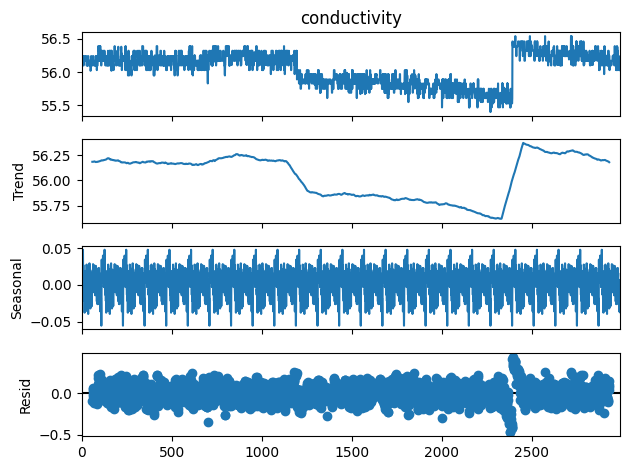

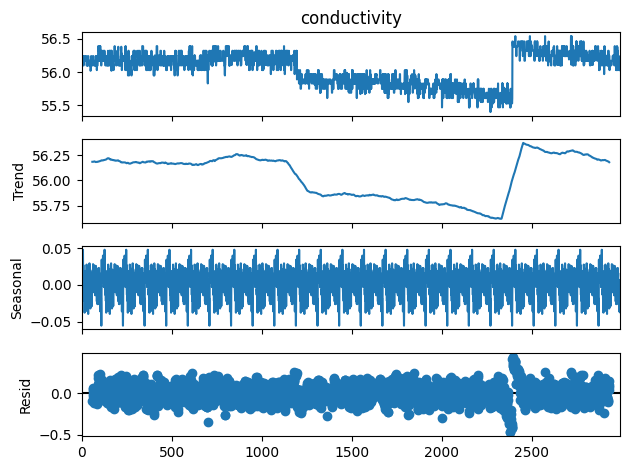

In [10]:
# Apply seasonal decomposition
result = seasonal_decompose(train_c_df['conductivity'], model='additive', period=120)
result.plot()

In [11]:
train_c_df.to_excel(r'Datasets/train_c_data.xlsx', index=False)

In [12]:
p_normal_df = filtered_df[filtered_df['Anomaly P'] == 'N']
p_normal_df = p_normal_df.drop(columns=['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V'])
p_normal_df = p_normal_df.reset_index(drop=True)
p_normal_df

,run_id,time_total,conductivity,pH,temperature,voltage
0,JUL_22_1,2,56.32,4.02,49.70,3.639
1,JUL_22_1,4,56.32,4.02,49.70,3.705
2,JUL_22_1,6,56.17,4.02,49.71,3.702
3,JUL_22_1,8,56.17,4.02,49.68,3.673
4,JUL_22_1,10,56.17,4.02,49.69,3.668
...,...,...,...,...,...,...
8963,JUL_24_3,20318,56.80,4.25,49.99,3.459
8964,JUL_24_3,20320,57.01,4.25,49.98,3.461
8965,JUL_24_3,20322,56.80,4.25,49.97,3.466
8966,JUL_24_3,20324,56.80,4.25,49.98,3.463


In [13]:
t_normal_df = filtered_df[filtered_df['Anomaly T'] == 'N']
t_normal_df = t_normal_df.drop(columns=['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V'])
t_normal_df = t_normal_df.reset_index(drop=True)
t_normal_df

,run_id,time_total,conductivity,pH,temperature,voltage
0,JUL_22_1,2,56.32,4.02,49.70,3.639
1,JUL_22_1,4,56.32,4.02,49.70,3.705
2,JUL_22_1,6,56.17,4.02,49.71,3.702
3,JUL_22_1,8,56.17,4.02,49.68,3.673
4,JUL_22_1,10,56.17,4.02,49.69,3.668
...,...,...,...,...,...,...
8963,JUL_24_3,20318,56.80,4.25,49.99,3.459
8964,JUL_24_3,20320,57.01,4.25,49.98,3.461
8965,JUL_24_3,20322,56.80,4.25,49.97,3.466
8966,JUL_24_3,20324,56.80,4.25,49.98,3.463


In [14]:
v_normal_df = filtered_df[filtered_df['Anomaly V'] == 'N']
v_normal_df = v_normal_df.drop(columns=['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V'])
v_normal_df = v_normal_df.reset_index(drop=True)
v_normal_df

,run_id,time_total,conductivity,pH,temperature,voltage
0,JUL_22_1,2,56.32,4.02,49.70,3.639
1,JUL_22_1,4,56.32,4.02,49.70,3.705
2,JUL_22_1,6,56.17,4.02,49.71,3.702
3,JUL_22_1,8,56.17,4.02,49.68,3.673
4,JUL_22_1,10,56.17,4.02,49.69,3.668
...,...,...,...,...,...,...
7139,JUL_23_5,16166,58.55,4.21,49.80,3.561
7140,JUL_23_5,16168,58.55,4.21,49.81,3.500
7141,JUL_23_5,16170,58.55,4.21,49.81,3.507
7142,JUL_23_5,16172,58.55,4.21,49.81,3.609


In [15]:
normal = (resampled_df['Anomaly C'] == 'N') & (resampled_df['Anomaly P'] == 'N') & (resampled_df['Anomaly T'] == 'N') & (resampled_df['Anomaly V'] == 'N')
normal_df = resampled_df[normal]
normal_df = normal_df.drop(columns=['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V'])
normal_df = normal_df.reset_index(drop=True)
normal_df['run_id'].value_counts()

run_id
JUL_22_4    598
JUL_22_7    598
JUL_22_5    598
JUL_22_6    595
JUL_22_2    577
JUL_22_8    574
JUL_22_1    172
Name: count, dtype: int64

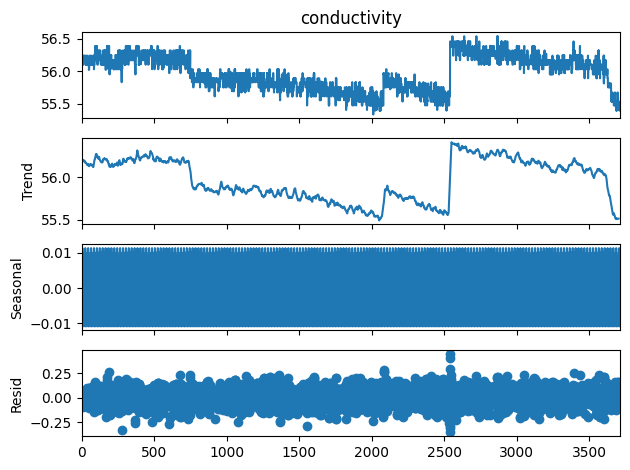

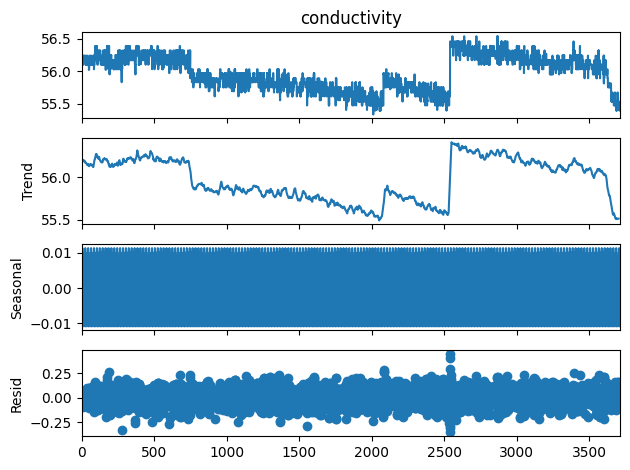

In [16]:
# Apply seasonal decomposition
result = seasonal_decompose(normal_df['conductivity'], model='additive', period=20)
result.plot()

In [17]:
valid_c = ['JUL_22_6', 'JUL_22_8']
valid_c_df = filtered_df[filtered_df['run_id'].isin(valid_c)]
valid_c_df['anomaly_label'] = (valid_c_df['Anomaly C'] != 'N').astype(int)
print(valid_c_df['Anomaly C'].unique())
valid_c_df = valid_c_df.drop(columns=['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V', 'pH', 'temperature', 'voltage'])
valid_c_df = valid_c_df.reset_index(drop=True)
valid_c_df['run_id'].value_counts()
valid_c_df

['N' 'C1' 'C2']


C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_11924\2702285570.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_c_df['anomaly_label'] = (valid_c_df['Anomaly C'] != 'N').astype(int)


,run_id,time_total,conductivity,anomaly_label
0,JUL_22_6,5980,55.67,0
1,JUL_22_6,5982,55.61,0
2,JUL_22_6,5984,55.61,0
3,JUL_22_6,5986,55.61,0
4,JUL_22_6,5988,55.55,0
...,...,...,...,...
1192,JUL_22_8,9560,56.46,1
1193,JUL_22_8,9562,56.46,1
1194,JUL_22_8,9564,56.46,1
1195,JUL_22_8,9566,56.46,1


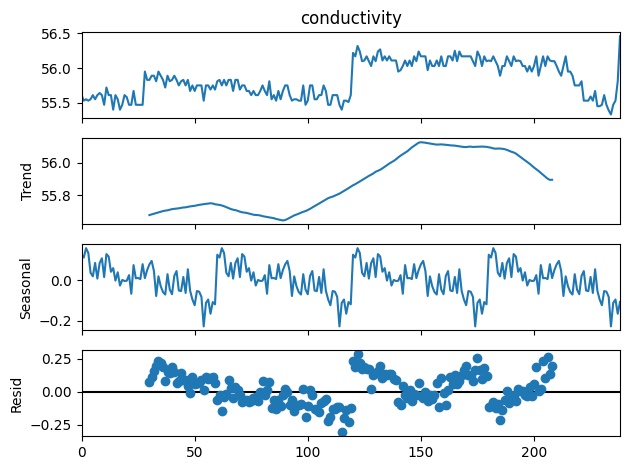

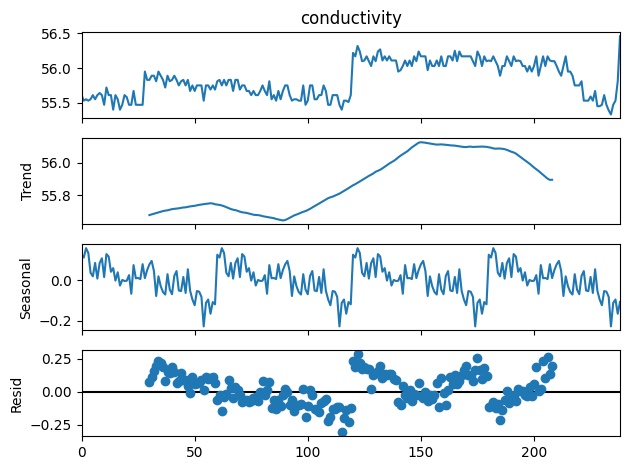

In [ ]:
# Apply seasonal decomposition
result = seasonal_decompose(valid_c_df['conductivity'], model='additive', period=60)
result.plot()

In [18]:
valid_c_df.to_excel(r'Datasets\valid_c_data.xlsx', index=False)

In [ ]:
normal_df.to_excel(r'Datasets\normal_data.xlsx', index=False)

In [ ]:
lstm_train_c_df = filtered_df[filtered_df['run_id'].isin(c_normasl)]
lstm_train_c_df['anomaly_label'] = (lstm_train_c_df['Anomaly C'] != 'N').astype(int)
lstm_train_c_df = lstm_train_c_df.drop(columns=['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V'])
lstm_train_c_df = lstm_train_c_df.reset_index(drop=True)
lstm_train_c_df

C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_5640\784557890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_train_c_df['anomaly_label'] = (lstm_train_c_df['Anomaly C'] != 'N').astype(int)


,run_id,time_total,conductivity,pH,temperature,voltage,anomaly_label
0,JUL_22_1,2,56.32,4.02,49.70,3.639,0
1,JUL_22_1,4,56.32,4.02,49.70,3.705,0
2,JUL_22_1,6,56.17,4.02,49.71,3.702,0
3,JUL_22_1,8,56.17,4.02,49.68,3.673,0
4,JUL_22_1,10,56.17,4.02,49.69,3.668,0
...,...,...,...,...,...,...,...
2985,JUL_22_7,8364,56.17,4.16,49.82,3.356,0
2986,JUL_22_7,8366,56.03,4.16,49.83,3.331,0
2987,JUL_22_7,8368,56.17,4.16,49.83,3.339,0
2988,JUL_22_7,8370,56.17,4.16,49.83,3.373,0


In [ ]:
lstm_train_c_df.to_excel(r'Datasets/lstm_train_c_data.xlsx', index=False)

In [ ]:
lstm_valid_c_df = filtered_df[filtered_df['run_id'].isin(valid_c)]
lstm_valid_c_df['anomaly_label'] = (lstm_valid_c_df['Anomaly C'] != 'N').astype(int)
lstm_valid_c_df = lstm_valid_c_df.drop(columns=['Anomaly C', 'Anomaly P', 'Anomaly T', 'Anomaly V'])
lstm_valid_c_df = lstm_valid_c_df.reset_index(drop=True)
lstm_valid_c_df.to_excel(r'Datasets/lstm_valid_c_data.xlsx', index=False)

C:\Users\kittyoomm\AppData\Local\Temp\ipykernel_5640\3658966579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lstm_valid_c_df['anomaly_label'] = (lstm_valid_c_df['Anomaly C'] != 'N').astype(int)
